# Retail Sales Prediction - Regression Problem

## 1. Problem Statement
The goal is to predict the **Total Monthly Sales** for each store based on various features like store size, location, and promotional activities.

## 2. Approach
*   **Data Loading**: Load the dataset from a CSV file.
*   **Data Cleaning**: Handle missing values and outliers.
*   **EDA**: Explore the data to understand its structure and relationships.
*   **Data Aggregation**: Convert daily transaction data into monthly store-level data.
*   **EDA**: Visualize relationships between sales and other variables.
*   **Feature Engineering**: Create new features to help the model.
*   **Modeling**: Build Linear Regression and Random Forest models.
*   **Evaluation**: Check how close our predictions are to reality.


# 1. Imports and Setup


In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Set plot style
sns.set_style("whitegrid")

# Display all columns
pd.set_option('display.max_columns', None)


## 3. Loading the Data
We will load the raw CSV files.


# 2. Data Loading & Inspection
> **[MENTAL MODEL] DataFrame as Dictionary of Series**  
> Think of a DataFrame (`df`) as a dictionary where Keys = Column Names and Values = Columns (Series).  
> `df['col_name']` accesses a full column.

**Universal Syntax Pattern:**
*   `df.head()`: First peek.
*   `df.info()`: Check data types and nulls.
*   `df.describe()`: Summary statistics.


In [4]:
# Load CSV files
stores = pd.read_csv('raw_data/STORES.csv')
promotions = pd.read_csv('raw_data/PROMOTIONS.csv')
store_promotions = pd.read_csv('raw_data/STORE_PROMOTIONS.csv')

# Load Transactions and Calendar (parsed dates)
transactions = pd.read_csv('raw_data/TRANSACTIONS.csv')
calendar = pd.read_csv('raw_data/CALENDAR.csv')

/var/folders/lq/l9_nf9611z552kdf863clz9w0000gp/T/ipykernel_51789/1709032470.py:7: DtypeWarning: Columns (7) have mixed types. Specify dtype option on import or set low_memory=False.
  transactions = pd.read_csv('raw_data/TRANSACTIONS.csv')


In [5]:
transactions['transaction_date']=pd.to_datetime(transactions['transaction_date'])
calendar['date']=pd.to_datetime(calendar['date'])

In [6]:
print("Transactions columns:", transactions.columns.tolist())

Transactions columns: ['transaction_id', 'store_id', 'transaction_date', 'customer_id', 'gross_bill_value', 'net_bill_value', 'total_items', 'promo_id', 'promo_discount_amount', 'payment_mode', 'category_mix']


In [7]:

transactions.head()

,transaction_id,store_id,transaction_date,customer_id,gross_bill_value,net_bill_value,total_items,promo_id,promo_discount_amount,payment_mode,category_mix
0,DF9EB4D75DE2,STR_001,2021-01-01 16:47:00,NaN,879.15,879.15,1,NaN,0.0,Cash,"{'Menswear': 0.44, 'Womenswear': 0.35, 'Kids':..."
1,EE13BED898BF,STR_001,2021-01-01 14:18:00,CUST_1414,2514.53,2514.53,1,NaN,0.0,Cash,"{'Menswear': 0.27, 'Womenswear': 0.28, 'Kids':..."
2,848A5549A6B4,STR_001,2021-01-01 10:26:00,NaN,6653.94,6653.94,5,NaN,0.0,Cash,"{'Menswear': 0.36, 'Womenswear': 0.27, 'Kids':..."
3,7CE95C5DA9FD,STR_001,2021-01-01 20:24:00,CUST_4995,1388.82,1388.82,1,NaN,0.0,Wallet,"{'Menswear': 0.38, 'Womenswear': 0.26, 'Kids':..."
4,9730BBB93950,STR_001,2021-01-01 13:56:00,NaN,5005.93,5005.93,2,NaN,0.0,Cash,"{'Menswear': 0.24, 'Womenswear': 0.54, 'Kids':..."


### 3a. Quick EDA on Raw Data (Before Aggregation)
We’ll build intuition first using simple, direct pandas + seaborn patterns:
- Weekend vs Weekday behavior (transactions, ATV, UPT)
- Festival vs Non-Festival days
- Monthly seasonality (Jan/Feb and Jul/Aug clearance peaks)
- Promotion-day impact (volume vs ATV)
- Basic data integrity checks

In [8]:
# Ensure a normalized date column for joins/EDA
transactions['date'] = transactions['transaction_date'].dt.normalize()


In [9]:
transactions.head(1)

,transaction_id,store_id,transaction_date,customer_id,gross_bill_value,net_bill_value,total_items,promo_id,promo_discount_amount,payment_mode,category_mix,date
0,DF9EB4D75DE2,STR_001,2021-01-01 16:47:00,NaN,879.15,879.15,1,NaN,0.0,Cash,"{'Menswear': 0.44, 'Womenswear': 0.35, 'Kids':...",2021-01-01


In [10]:
# Merge calendar flags onto transactions (date-level)
trx_cal = pd.merge(
    transactions,
    calendar[['date', 'is_weekend', 'is_festive_period', 'festival_name']],
    on='date', how='left'
)

In [11]:
# Daily store metrics for simple comparisons
daily_store = trx_cal.groupby(['store_id', 'date']).agg(
    total_sales=('net_bill_value', 'sum'),
    total_transactions=('transaction_id', 'count'),
    total_items=('total_items', 'sum'),
    total_discount=('promo_discount_amount', 'sum'),
    is_weekend=('is_weekend', 'max'),
    is_festive_period=('is_festive_period', 'max')
).reset_index()

In [12]:
# Derived metrics
daily_store['ATV'] = daily_store['total_sales'] / daily_store['total_transactions']
daily_store['UPT'] = daily_store['total_items'] / daily_store['total_transactions']

daily_store.head()

,store_id,date,total_sales,total_transactions,total_items,total_discount,is_weekend,is_festive_period,ATV,UPT
0,STR_001,2021-01-01,251482.01,39,130,0.0,0,0,6448.256667,3.333333
1,STR_001,2021-01-02,402418.13,69,223,0.0,1,0,5832.146812,3.231884
2,STR_001,2021-01-03,507863.88,87,275,0.0,1,0,5837.515862,3.160920
3,STR_001,2021-01-04,233032.08,43,142,0.0,0,0,5419.350698,3.302326
4,STR_001,2021-01-05,232128.78,46,148,0.0,0,0,5046.277826,3.217391


In [13]:
# 1) Weekend vs Weekday behavior
by_weekend = daily_store.groupby('is_weekend')[['total_transactions', 'ATV', 'UPT']].mean().reset_index()
print(by_weekend)

   is_weekend  total_transactions          ATV       UPT
0           0           58.029126  6289.180622  3.659439
1           1           86.142605  6285.303019  3.654585


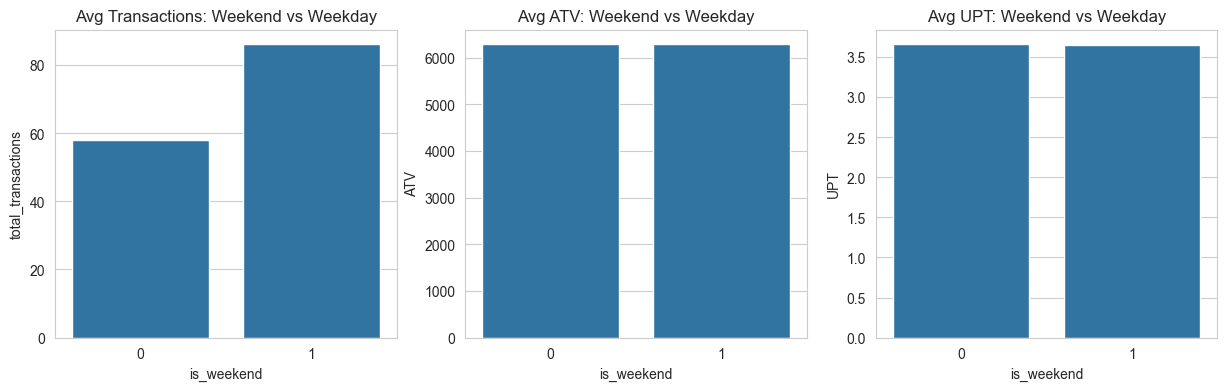

In [14]:
fig, axs = plt.subplots(1, 3, figsize=(15, 4))
sns.barplot(data=by_weekend, x='is_weekend', y='total_transactions', ax=axs[0])
axs[0].set_title('Avg Transactions: Weekend vs Weekday')

sns.barplot(data=by_weekend, x='is_weekend', y='ATV', ax=axs[1])
axs[1].set_title('Avg ATV: Weekend vs Weekday')

sns.barplot(data=by_weekend, x='is_weekend', y='UPT', ax=axs[2])
axs[2].set_title('Avg UPT: Weekend vs Weekday')
plt.show()

In [15]:
# 2) Festival vs Non-Festival days (calendar-driven)
by_festival = daily_store.groupby('is_festive_period')[['total_transactions', 'ATV', 'UPT']].mean().reset_index()
print(by_festival)

   is_festive_period  total_transactions          ATV       UPT
0                  0           64.766092  6261.786180  3.642578
1                  1          124.104500  7461.739754  4.348960


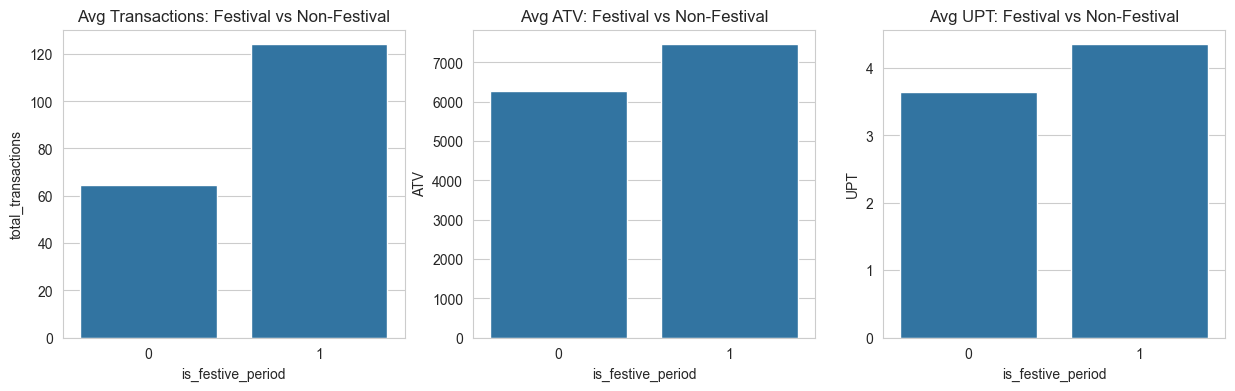

In [16]:
fig, axs = plt.subplots(1, 3, figsize=(15, 4))
sns.barplot(data=by_festival, x='is_festive_period', y='total_transactions', ax=axs[0])
axs[0].set_title('Avg Transactions: Festival vs Non-Festival')

sns.barplot(data=by_festival, x='is_festive_period', y='ATV', ax=axs[1])
axs[1].set_title('Avg ATV: Festival vs Non-Festival')

sns.barplot(data=by_festival, x='is_festive_period', y='UPT', ax=axs[2])
axs[2].set_title('Avg UPT: Festival vs Non-Festival')
plt.show()

In [17]:
# 3) Monthly seasonality (transactions by month)
daily_store['year'] = daily_store['date'].dt.year
daily_store['month'] = daily_store['date'].dt.month
monthly_trx = daily_store.groupby(['year','month'])['total_transactions'].mean().reset_index()

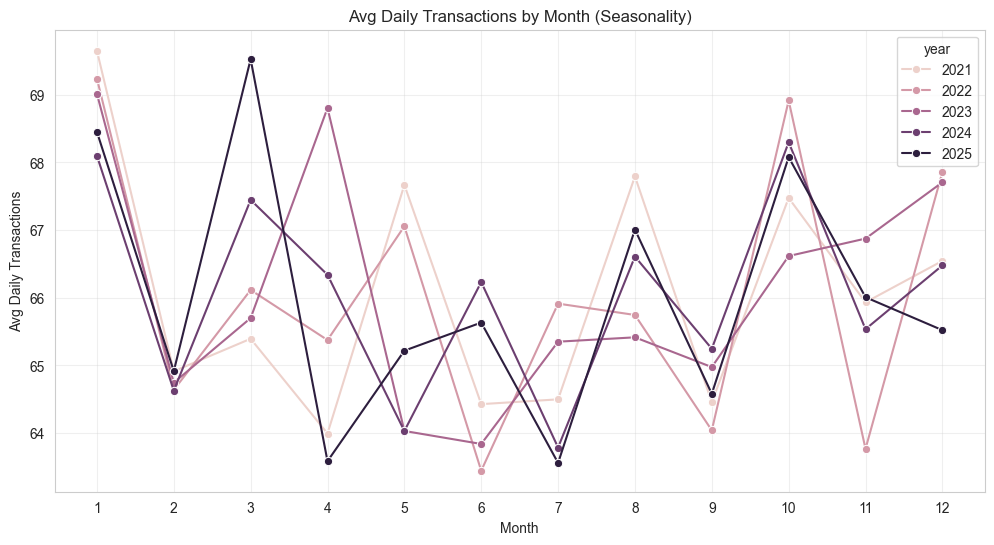

In [18]:
plt.figure(figsize=(12, 6))
sns.lineplot(data=monthly_trx, x='month', y='total_transactions', hue='year', marker='o')
plt.title('Avg Daily Transactions by Month (Seasonality)')
plt.xticks(ticks=range(1, 13))
plt.xlabel('Month')
plt.ylabel('Avg Daily Transactions')
plt.grid(True, alpha=0.3)
plt.show()

In [19]:
# 5) Basic Data Integrity Checks (quick sanity)

# 5a) Net <= Gross
pct_ok = (transactions['net_bill_value'] <= transactions['gross_bill_value']).mean() * 100
if pct_ok < 100:
    print("WARNING: Some rows have Net > Gross!")
else:
    print(f"Net <= Gross passes on {pct_ok:.1f}% of rows")

Net <= Gross passes on 100.0% of rows


In [20]:
# 5b) gross - net ≈ promo_discount_amount (within small tolerance)
diff = (transactions['gross_bill_value'] - transactions['net_bill_value'])
close = (diff - transactions['promo_discount_amount']).abs() < 1e-3
print(f"Discount consistency within tolerance on {close.mean()*100:.1f}% of rows")

Discount consistency within tolerance on 97.2% of rows


In [21]:
# 5c) Customer ID null ratio
null_ratio = transactions['customer_id'].isna().mean() * 100
print(f"Customer ID nulls: {null_ratio:.1f}% (walk-ins)")

Customer ID nulls: 30.0% (walk-ins)


## 4. Data Processing: Creating the Monthly Dataset

Our transactions are at a granular level (one row per bill). We need to aggregatre this to a **Store-Month** level to predict monthly sales.

### Step 1: Create Month and Year Columns


In [22]:
transactions['year'] = transactions['transaction_date'].dt.year
transactions['month'] = transactions['transaction_date'].dt.month

transactions.head()


,transaction_id,store_id,transaction_date,customer_id,gross_bill_value,net_bill_value,total_items,promo_id,promo_discount_amount,payment_mode,category_mix,date,year,month
0,DF9EB4D75DE2,STR_001,2021-01-01 16:47:00,NaN,879.15,879.15,1,NaN,0.0,Cash,"{'Menswear': 0.44, 'Womenswear': 0.35, 'Kids':...",2021-01-01,2021,1
1,EE13BED898BF,STR_001,2021-01-01 14:18:00,CUST_1414,2514.53,2514.53,1,NaN,0.0,Cash,"{'Menswear': 0.27, 'Womenswear': 0.28, 'Kids':...",2021-01-01,2021,1
2,848A5549A6B4,STR_001,2021-01-01 10:26:00,NaN,6653.94,6653.94,5,NaN,0.0,Cash,"{'Menswear': 0.36, 'Womenswear': 0.27, 'Kids':...",2021-01-01,2021,1
3,7CE95C5DA9FD,STR_001,2021-01-01 20:24:00,CUST_4995,1388.82,1388.82,1,NaN,0.0,Wallet,"{'Menswear': 0.38, 'Womenswear': 0.26, 'Kids':...",2021-01-01,2021,1
4,9730BBB93950,STR_001,2021-01-01 13:56:00,NaN,5005.93,5005.93,2,NaN,0.0,Cash,"{'Menswear': 0.24, 'Womenswear': 0.54, 'Kids':...",2021-01-01,2021,1


### Step 2: Aggregate Transactions
We will group by `store_id`, `year`, and `month` to calculate total sales and other metrics.


In [23]:
# Aggregate to Store-Month using named aggregation
monthly_sales = transactions.groupby(['store_id', 'year', 'month']).agg(
    total_sales=('net_bill_value', 'sum'),
    total_transactions=('transaction_id', 'count'),
    total_items=('total_items', 'sum')
).reset_index()

In [24]:
monthly_sales.head()

,store_id,year,month,total_sales,total_transactions,total_items
0,STR_001,2021,1,10126415.82,1919,5831
1,STR_001,2021,2,7777073.88,1539,4712
2,STR_001,2021,3,8928107.61,1722,5204
3,STR_001,2021,4,8882281.60,1630,5059
4,STR_001,2021,5,9471397.20,1814,5590


### Step 3: Merge Store Metadata
We need to add store information (like City, Size, Format) to our monthly sales data.


In [25]:
# Merge with STORES data
df_merged = pd.merge(monthly_sales, stores, on='store_id', how='left')
df_merged.head()


,store_id,year,month,total_sales,total_transactions,total_items,city,state,location_type,store_format,store_size_sqft,launch_date,competition_density,avg_monthly_footfall,avg_monthly_sales,zone
0,STR_001,2021,1,10126415.82,1919,5831,Ahmedabad,Gujarat,Rural,Medium High-Street,5000,2018-02-12,5,5457,7442362,West
1,STR_001,2021,2,7777073.88,1539,4712,Ahmedabad,Gujarat,Rural,Medium High-Street,5000,2018-02-12,5,5457,7442362,West
2,STR_001,2021,3,8928107.61,1722,5204,Ahmedabad,Gujarat,Rural,Medium High-Street,5000,2018-02-12,5,5457,7442362,West
3,STR_001,2021,4,8882281.60,1630,5059,Ahmedabad,Gujarat,Rural,Medium High-Street,5000,2018-02-12,5,5457,7442362,West
4,STR_001,2021,5,9471397.20,1814,5590,Ahmedabad,Gujarat,Rural,Medium High-Street,5000,2018-02-12,5,5457,7442362,West


### Step 3a: Add Monthly Calendar Features
From `CALENDAR.csv`, create monthly features shared by all stores:
- `days_festive`: days flagged as festive period
- `days_festival_named`: days with a non-empty `festival_name`
- `days_weekend`: weekend days in the month
- `days_in_month`: count of days in the month

In [26]:
# Aggregate to month/year level
cal_monthly = calendar.groupby(['year', 'month']).agg(
    days_festive=('is_festive_period', 'sum'),
    days_festival_named=('festival_name', 'sum'),
    days_weekend=('is_weekend', 'sum'),
    days_in_month=('date', 'count')
).reset_index()


In [27]:
cal_monthly.head()

,year,month,days_festive,days_festival_named,days_weekend,days_in_month
0,2021,1,2,PongalRepublic Day,10,31
1,2021,2,0,0,8,28
2,2021,3,1,Holi,8,31
3,2021,4,0,0,8,30
4,2021,5,1,Eid,10,31


In [28]:
# Merge into the store-month dataset (same values for all stores in a month)
df_merged = pd.merge(df_merged, cal_monthly, on=['year', 'month'], how='left')

In [29]:
df_merged.head()

,store_id,year,month,total_sales,total_transactions,total_items,city,state,location_type,store_format,store_size_sqft,launch_date,competition_density,avg_monthly_footfall,avg_monthly_sales,zone,days_festive,days_festival_named,days_weekend,days_in_month
0,STR_001,2021,1,10126415.82,1919,5831,Ahmedabad,Gujarat,Rural,Medium High-Street,5000,2018-02-12,5,5457,7442362,West,2,PongalRepublic Day,10,31
1,STR_001,2021,2,7777073.88,1539,4712,Ahmedabad,Gujarat,Rural,Medium High-Street,5000,2018-02-12,5,5457,7442362,West,0,0,8,28
2,STR_001,2021,3,8928107.61,1722,5204,Ahmedabad,Gujarat,Rural,Medium High-Street,5000,2018-02-12,5,5457,7442362,West,1,Holi,8,31
3,STR_001,2021,4,8882281.60,1630,5059,Ahmedabad,Gujarat,Rural,Medium High-Street,5000,2018-02-12,5,5457,7442362,West,0,0,8,30
4,STR_001,2021,5,9471397.20,1814,5590,Ahmedabad,Gujarat,Rural,Medium High-Street,5000,2018-02-12,5,5457,7442362,West,1,Eid,10,31


## 5. Feature Engineering: Promotions

This is the most critical step. We need to know how many days a specific promotion was active for a store in a given month.

We will create a function to calculate this.


In [30]:
from datetime import datetime, timedelta

# Merge promo type into store_promotions for easier filtering
store_promotions_merged = pd.merge(store_promotions, promotions[['promo_id', 'promo_type']], on='promo_id', how='left')

# Convert dates to datetime objects
store_promotions_merged['start_date'] = pd.to_datetime(store_promotions_merged['start_date'])
store_promotions_merged['end_date'] = pd.to_datetime(store_promotions_merged['end_date'])

def calculate_active_days(store_id, year, month, promo_type, promo_df):
    
    # 1. Define the start and end of the month
    month_start = datetime(year, month, 1)
    if month == 12:
        month_end = datetime(year, 12, 31)
    else:
        month_end = datetime(year, month + 1, 1) - timedelta(days=1)
        
    # 2. Filter for specific store and promo type
    relevant_promos = promo_df[
        (promo_df['store_id'] == store_id) & 
        (promo_df['promo_type'] == promo_type)
    ]
    
    total_days = 0
    
    # 3. Calculate overlap
    for _, row in relevant_promos.iterrows():
        # Find overlap start and end
        overlap_start = max(month_start, row['start_date'])
        overlap_end = min(month_end, row['end_date'])
        
        # Check if there is an actual overlap
        if overlap_start <= overlap_end:
            days = (overlap_end - overlap_start).days + 1
            total_days += days
            
    return total_days


Now we apply this function to create new columns for each promotion type. 
*Note: This might take a minute to run.*


In [31]:
# Get unique promotion types
promo_types = promotions['promo_type'].unique()

for p_type in promo_types:
    col_name = f'days_{p_type}'
    print(f"Calculating {col_name}...")
    
    # Use apply with a lambda function
    df_merged[col_name] = df_merged.apply(
        lambda row: calculate_active_days(row['store_id'], row['year'], row['month'], p_type, store_promotions_merged), 
        axis=1
    )

print("Feature Engineering Complete.")


Calculating days_BOGO...
Calculating days_Flat_50...
Calculating days_Kids_Special...
Calculating days_Summer_Sale...
Calculating days_Festive_Bonanza...
Calculating days_Clearance...
Feature Engineering Complete.


In [32]:
df_merged.head()

,store_id,year,month,total_sales,total_transactions,total_items,city,state,location_type,store_format,store_size_sqft,launch_date,competition_density,avg_monthly_footfall,avg_monthly_sales,zone,days_festive,days_festival_named,days_weekend,days_in_month,days_BOGO,days_Flat_50,days_Kids_Special,days_Summer_Sale,days_Festive_Bonanza,days_Clearance
0,STR_001,2021,1,10126415.82,1919,5831,Ahmedabad,Gujarat,Rural,Medium High-Street,5000,2018-02-12,5,5457,7442362,West,2,PongalRepublic Day,10,31,0,0,0,0,0,12
1,STR_001,2021,2,7777073.88,1539,4712,Ahmedabad,Gujarat,Rural,Medium High-Street,5000,2018-02-12,5,5457,7442362,West,0,0,8,28,0,12,0,0,0,0
2,STR_001,2021,3,8928107.61,1722,5204,Ahmedabad,Gujarat,Rural,Medium High-Street,5000,2018-02-12,5,5457,7442362,West,1,Holi,8,31,0,0,13,0,0,0
3,STR_001,2021,4,8882281.60,1630,5059,Ahmedabad,Gujarat,Rural,Medium High-Street,5000,2018-02-12,5,5457,7442362,West,0,0,8,30,0,0,0,9,0,0
4,STR_001,2021,5,9471397.20,1814,5590,Ahmedabad,Gujarat,Rural,Medium High-Street,5000,2018-02-12,5,5457,7442362,West,1,Eid,10,31,0,0,0,0,15,0


In [33]:
df_merged.to_csv('Final_Monthly_Dataset.csv', index=False)

In [34]:
df_merged=pd.read_csv('Final_Monthly_Dataset.csv')

# 3. Exploratory Data Analysis (EDA)
> **[MENTAL MODEL] The "Artist" Model for Plotting**  
> 1.  Create a "Canvas" (Figure) and "Subplots" (Axes). `fig, ax = plt.subplots()`  
> 2.  Hand the Axes (`ax`) to a plotter (Seaborn). `sns.plot(..., ax=ax)`  
> 3.  Customize the Axes. `ax.set_title(...)`

> **[MENTAL MODEL] Data-Centric Plotting**  
> Give Seaborn the *whole dataframe* and map columns to aesthetics (x, y, color).
> `sns.scatterplot(data=df, x='col_A', y='col_B')`


## 6. Exploratory Data Analysis (EDA)

Let's understand our data before modeling.


### 6.1 Distribution of Sales


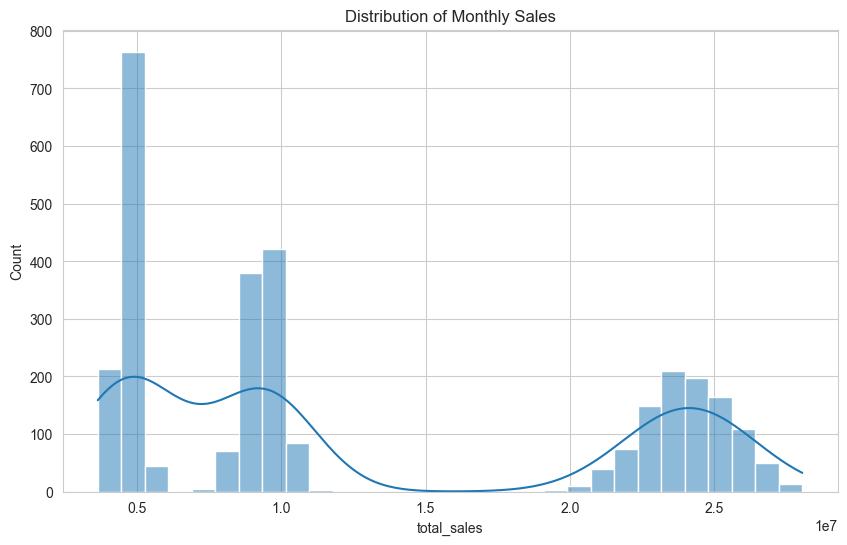

In [35]:
plt.figure(figsize=(10, 6))
sns.histplot(data=df_merged, x='total_sales', kde=True, bins=30)
plt.title('Distribution of Monthly Sales')
plt.show()


### 6.2 Sales vs Store Size


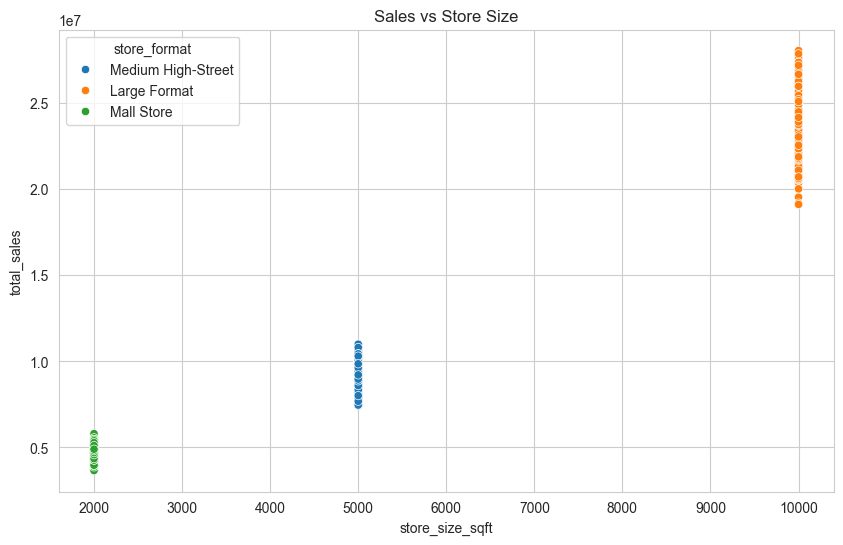

In [36]:
# Visualization: Sales vs Store Size
import matplotlib.pyplot as plt
import seaborn as sns

fig, ax = plt.subplots(figsize=(10, 6))
sns.scatterplot(data=df_merged, x='store_size_sqft', y='total_sales', hue='store_format', ax=ax)
ax.set_title('Sales vs Store Size')
plt.show()


### 6.3 Sales vs Location Type


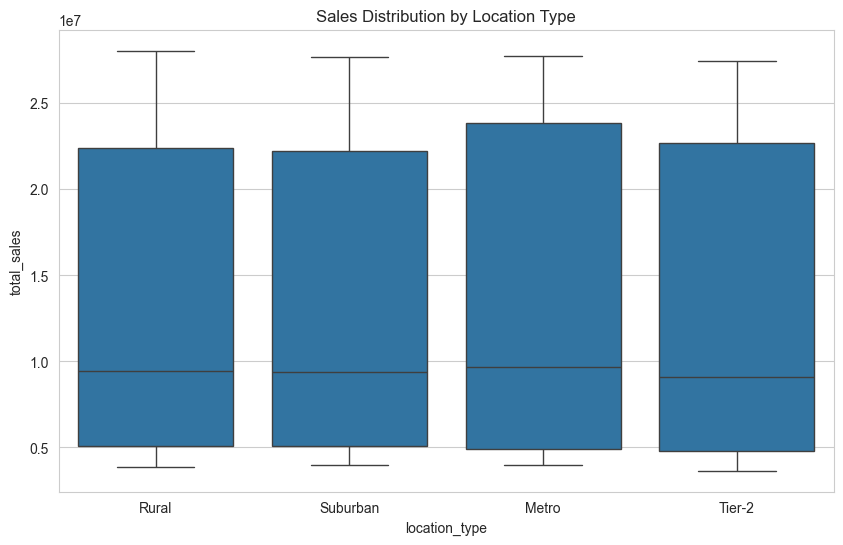

In [37]:
#Visualization: Sales Distribution by Location Type
fig, ax = plt.subplots(figsize=(10, 6))
sns.boxplot(data=df_merged, x='location_type', y='total_sales', ax=ax)
ax.set_title('Sales Distribution by Location Type')
plt.show()


### 6.4 Sales Over Time (Seasonality)


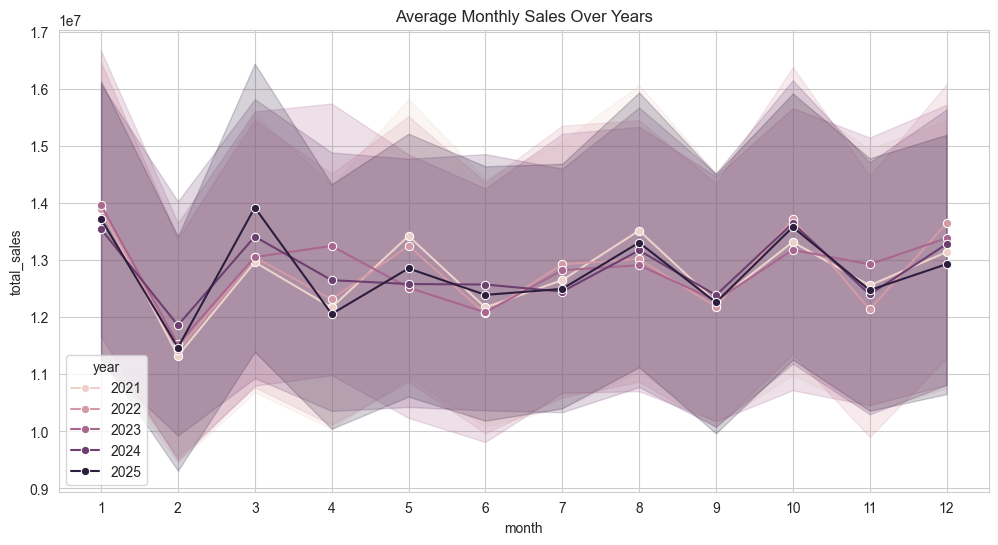

In [38]:
plt.figure(figsize=(12, 6))
sns.lineplot(data=df_merged, x='month', y='total_sales', hue='year', estimator='mean', marker='o')
plt.title('Average Monthly Sales Over Years')
plt.xticks(range(1, 13))
plt.show()


## 7. Pre-processing for Machine Learning

### Step 1: Handling Categorical Variables
We use **OneHotEncoder** to convert text columns (City, Location, Format) into numbers.


In [39]:

# Select features
numerical_cols = ['store_size_sqft', 'competition_density', 'avg_monthly_footfall'] \
    + [c for c in df_merged.columns if c.startswith('days_')]  # include promo + calendar day counts
categorical_cols = ['city', 'location_type', 'store_format', 'zone']
target = 'total_sales'

In [40]:
df_merged.head()

,store_id,year,month,total_sales,total_transactions,total_items,city,state,location_type,store_format,store_size_sqft,launch_date,competition_density,avg_monthly_footfall,avg_monthly_sales,zone,days_festive,days_festival_named,days_weekend,days_in_month,days_BOGO,days_Flat_50,days_Kids_Special,days_Summer_Sale,days_Festive_Bonanza,days_Clearance
0,STR_001,2021,1,10126415.82,1919,5831,Ahmedabad,Gujarat,Rural,Medium High-Street,5000,2018-02-12,5,5457,7442362,West,2,PongalRepublic Day,10,31,0,0,0,0,0,12
1,STR_001,2021,2,7777073.88,1539,4712,Ahmedabad,Gujarat,Rural,Medium High-Street,5000,2018-02-12,5,5457,7442362,West,0,0,8,28,0,12,0,0,0,0
2,STR_001,2021,3,8928107.61,1722,5204,Ahmedabad,Gujarat,Rural,Medium High-Street,5000,2018-02-12,5,5457,7442362,West,1,Holi,8,31,0,0,13,0,0,0
3,STR_001,2021,4,8882281.60,1630,5059,Ahmedabad,Gujarat,Rural,Medium High-Street,5000,2018-02-12,5,5457,7442362,West,0,0,8,30,0,0,0,9,0,0
4,STR_001,2021,5,9471397.20,1814,5590,Ahmedabad,Gujarat,Rural,Medium High-Street,5000,2018-02-12,5,5457,7442362,West,1,Eid,10,31,0,0,0,0,15,0


In [41]:
# Feature Selection
# Drop target and Date (not useful for this regression)
# We keep categorical columns raw for the Pipeline to handle.
X = df_merged.drop(['total_sales', 'Date'], axis=1, errors='ignore')
y = df_merged['total_sales']

# Identify categorical and numerical columns for later processing
# We infer this from types or hardcode known cats.
categorical_cols = ['store_format', 'location_type', 'city', 'state', 'zone','days_festival_named']
numerical_cols = [c for c in X.columns if c not in categorical_cols and c != 'store_id' and c != 'launch_date']

print(f"Categorical: {categorical_cols}")
print(f"Numerical: {numerical_cols}")
print("X shape:", X.shape)


Categorical: ['store_format', 'location_type', 'city', 'state', 'zone', 'days_festival_named']
Numerical: ['year', 'month', 'total_transactions', 'total_items', 'store_size_sqft', 'competition_density', 'avg_monthly_footfall', 'avg_monthly_sales', 'days_festive', 'days_weekend', 'days_in_month', 'days_BOGO', 'days_Flat_50', 'days_Kids_Special', 'days_Summer_Sale', 'days_Festive_Bonanza', 'days_Clearance']
X shape: (3000, 25)


### Step 2: Train-Test Split
Since we have time-series data, random splitting is bad. We will use a **Time-based Split**.
*   **Train**: 2021, 2022
*   **Test**: 2023


In [42]:
# Create masks for split
train_mask = (df_merged['year'] <= 2024)
test_mask = (df_merged['year'] == 2025)

X_train = X[train_mask]
y_train = y[train_mask]
X_test = X[test_mask]
y_test = y[test_mask]

print(f"Train Set: {X_train.shape}")
print(f"Test Set: {X_test.shape}")


Train Set: (2400, 25)
Test Set: (600, 25)


### Step 3: Scaling
Scale numerical features to ensure fair comparison.


In [43]:
# Preprocessing Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
import pandas as pd

# Define the ColumnTransformer
# fit_transform on X_train ensures we learn scaling/encoding params from train set only.
# Using sparse_output=False to get dense arrays for DataFrame creation
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_cols),
        ('cat', OneHotEncoder(drop='first', handle_unknown='ignore', sparse_output=False), categorical_cols)
    ],
    verbose_feature_names_out=False
)

# Fit and Transform Train
X_train_scaled_array = preprocessor.fit_transform(X_train)
X_test_scaled_array = preprocessor.transform(X_test)

# Convert back to DataFrame to preserve column names for feature importance
try:
    feature_names = preprocessor.get_feature_names_out()
except AttributeError:
    feature_names = [f"feat_{i}" for i in range(X_train_scaled_array.shape[1])]

X_train_scaled = pd.DataFrame(X_train_scaled_array, columns=feature_names, index=X_train.index)
X_test_scaled = pd.DataFrame(X_test_scaled_array, columns=feature_names, index=X_test.index)

print("Preprocessing complete with ColumnTransformer.")
print(f"Train Shape: {X_train_scaled.shape}")


Preprocessing complete with ColumnTransformer.
Train Shape: (2400, 46)


/Users/ramatiwari/Library/Mobile Documents/com~apple~CloudDocs/Teaching/Promotion_dataset/.venv/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [5] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(msg, UserWarning)


## 8. Machine Learning Models

### Model 1: Linear Regression (Baseline)


# 4. Machine Learning: The Estimator API


In [44]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

lr_model = LinearRegression()
lr_model.fit(X_train_scaled, y_train)


,"fit_intercept fit_intercept: bool, default=TrueWhether to calculate the intercept for this model. If setto False, no intercept will be used in calculations(i.e. data is expected to be centered).",True
,"copy_X copy_X: bool, default=TrueIf True, X will be copied; else, it may be overwritten.",True
,"tol tol: float, default=1e-6The precision of the solution (`coef_`) is determined by `tol` whichspecifies a different convergence criterion for the `lsqr` solver.`tol` is set as `atol` and `btol` of :func:`scipy.sparse.linalg.lsqr` whenfitting on sparse training data. This parameter has no effect when fittingon dense data... versionadded:: 1.7",1e-06
,"n_jobs n_jobs: int, default=NoneThe number of jobs to use for the computation. This will only providespeedup in case of sufficiently large problems, that is if firstly`n_targets > 1` and secondly `X` is sparse or if `positive` is setto `True`. ``None`` means 1 unless in a:obj:`joblib.parallel_backend` context. ``-1`` means using allprocessors. See :term:`Glossary ` for more details.",None
,"positive positive: bool, default=FalseWhen set to ``True``, forces the coefficients to be positive. Thisoption is only supported for dense arrays.For a comparison between a linear regression model with positive constraintson the regression coefficients and a linear regression without such constraints,see :ref:`sphx_glr_auto_examples_linear_model_plot_nnls.py`... versionadded:: 0.24",False


In [45]:
# Predict
y_pred_lr = lr_model.predict(X_test_scaled)

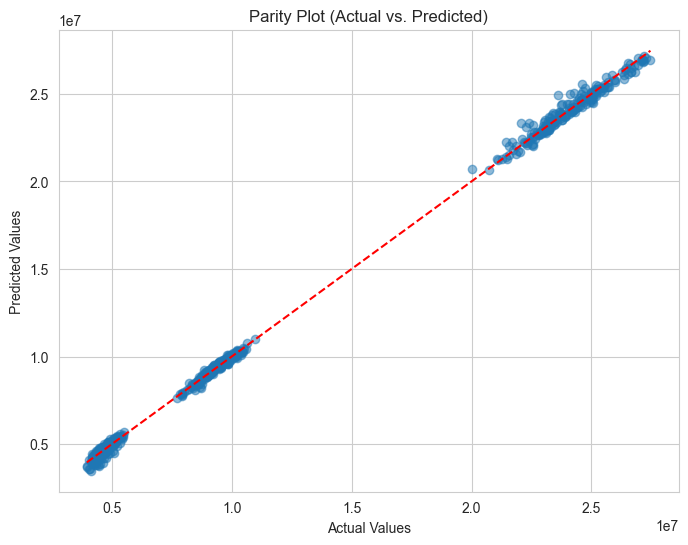

In [46]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_pred_lr, alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], color='red', linestyle='--')
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.title('Parity Plot (Actual vs. Predicted)')
plt.grid(True)
plt.show()



In [47]:
# Evaluate
rmse_lr = np.sqrt(mean_squared_error(y_test, y_pred_lr))
print(f"Linear Regression RMSE: {round(rmse_lr, 2)}")

Linear Regression RMSE: 236823.33


### Model 2: Random Forest Regressor


In [48]:
from sklearn.ensemble import RandomForestRegressor

rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X_train_scaled, y_train)


,"n_estimators n_estimators: int, default=100The number of trees in the forest... versionchanged:: 0.22 The default value of ``n_estimators`` changed from 10 to 100 in 0.22.",100
,"criterion criterion: {""squared_error"", ""absolute_error"", ""friedman_mse"", ""poisson""}, default=""squared_error""The function to measure the quality of a split. Supported criteriaare ""squared_error"" for the mean squared error, which is equal tovariance reduction as feature selection criterion and minimizes the L2loss using the mean of each terminal node, ""friedman_mse"", which usesmean squared error with Friedman's improvement score for potentialsplits, ""absolute_error"" for the mean absolute error, which minimizesthe L1 loss using the median of each terminal node, and ""poisson"" whichuses reduction in Poisson deviance to find splits.Training using ""absolute_error"" is significantly slowerthan when using ""squared_error""... versionadded:: 0.18 Mean Absolute Error (MAE) criterion... versionadded:: 1.0 Poisson criterion.",'squared_error'
,"max_depth max_depth: int, default=NoneThe maximum depth of the tree. If None, then nodes are expanded untilall leaves are pure or until all leaves contain less thanmin_samples_split samples.",None
,"min_samples_split min_samples_split: int or float, default=2The minimum number of samples required to split an internal node:- If int, then consider `min_samples_split` as the minimum number.- If float, then `min_samples_split` is a fraction and `ceil(min_samples_split * n_samples)` are the minimum number of samples for each split... versionchanged:: 0.18 Added float values for fractions.",2
,"min_samples_leaf min_samples_leaf: int or float, default=1The minimum number of samples required to be at a leaf node.A split point at any depth will only be considered if it leaves atleast ``min_samples_leaf`` training samples in each of the left andright branches. This may have the effect of smoothing the model,especially in regression.- If int, then consider `min_samples_leaf` as the minimum number.- If float, then `min_samples_leaf` is a fraction and `ceil(min_samples_leaf * n_samples)` are the minimum number of samples for each node... versionchanged:: 0.18 Added float values for fractions.",1
,"min_weight_fraction_leaf min_weight_fraction_leaf: float, default=0.0The minimum weighted fraction of the sum total of weights (of allthe input samples) required to be at a leaf node. Samples haveequal weight when sample_weight is not provided.",0.0
,"max_features max_features: {""sqrt"", ""log2"", None}, int or float, default=1.0The number of features to consider when looking for the best split:- If int, then consider `max_features` features at each split.- If float, then `max_features` is a fraction and `max(1, int(max_features * n_features_in_))` features are considered at each split.- If ""sqrt"", then `max_features=sqrt(n_features)`.- If ""log2"", then `max_features=log2(n_features)`.- If None or 1.0, then `max_features=n_features`... note:: The default of 1.0 is equivalent to bagged trees and more randomness can be achieved by setting smaller values, e.g. 0.3... versionchanged:: 1.1 The default of `max_features` changed from `""auto""` to 1.0.Note: the search for a split does not stop until at least onevalid partition of the node samples is found, even if it requires toeffectively inspect more than ``max_features`` features.",1.0
,"max_leaf_nodes max_leaf_nodes: int, default=NoneGrow trees with ``max_leaf_nodes`` in best-first fashion.Best nodes are defined as relative reduction in impurity.If None then unlimited number of leaf nodes.",None
,"min_impurity_decrease min_impurity_decrease: float, default=0.0A node will be split if this split induces a decrease of the impuritygreater than or equal to this value.The weighted impurity decrease equation is the following:: N_t / N * (impurity - N_t_R / N_t * right_impurity - N_t_L / N_t * left_impurity)where ``N`` is the total number of samples, ``N_t`` is the number ofsample

In [49]:
# save the model
import pickle
pickle.dump(rf_model, open('RandomForestModel', 'wb'))

In [50]:
rf_model=pickle.load(open('RandomForestModel', 'rb'))

In [51]:
# Predict
y_pred_rf = rf_model.predict(X_test_scaled)


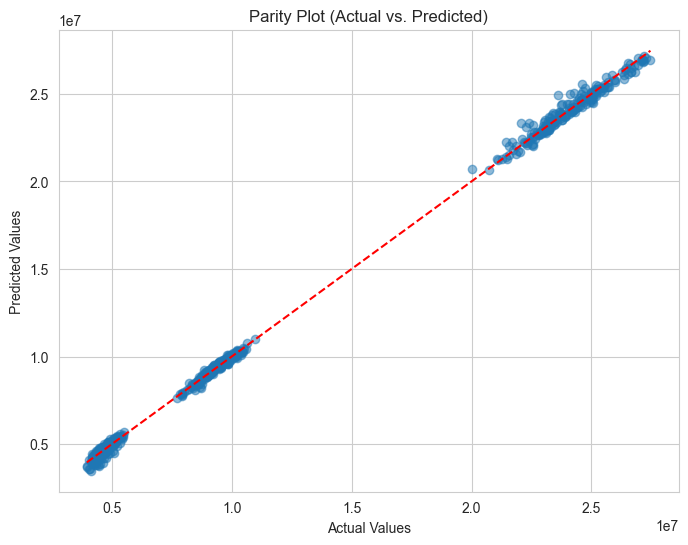

In [52]:
# parity plots to see the predict
plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_pred_lr, alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], color='red', linestyle='--')
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.title('Parity Plot (Actual vs. Predicted)')
plt.grid(True)
plt.show()


In [53]:
# Evaluate
rmse_rf = np.sqrt(mean_squared_error(y_test, y_pred_rf))
print(f"Random Forest RMSE: {round(rmse_rf, 2)}")

Random Forest RMSE: 196849.05


### 8.1 Cross-Validation
To ensure our model's performance is consistent and not just a fluke of our train-test split, we use **Cross-Validation**.


In [198]:
from sklearn.model_selection import cross_val_score

# Use Negative MSE because cross_val_score tries to maximize the score (so higher is better)
# We want to minimize error, so we flip the sign later.
scores = cross_val_score(rf_model, X_train_scaled, y_train, scoring='neg_mean_squared_error', cv=5)

rmse_scores = np.sqrt(-scores)
print(f"Cross-Validation RMSE Scores: {np.round(rmse_scores, 2)}")
print(f"Average RMSE: {round(rmse_scores.mean(), 2)}")


Cross-Validation RMSE Scores: [192392.38 164349.84 237864.87 203437.37 215959.8 ]
Average RMSE: 202800.85


### 8.2 Hyperparameter Tuning (GridSearchCV)
We can improve our Random Forest by finding the best settings (hyperparameters).


In [199]:
from sklearn.model_selection import GridSearchCV

# 1. Define the parameter grid
param_grid = {
    'n_estimators': [50, 100],
    'max_depth': [10, 20, None],
    'min_samples_split': [2, 5]
}


In [200]:
# 2. Initialize the Grid Search
grid_search = GridSearchCV(
    estimator=RandomForestRegressor(random_state=42),
    param_grid=param_grid,
    cv=3, # 3-fold CV to save time
    scoring='neg_mean_squared_error',
    n_jobs=-1 # Use all processors
)

In [201]:
# 3. Fit
print("Starting Grid Search... this may take a moment.")
grid_search.fit(X_train_scaled, y_train)

Starting Grid Search... this may take a moment.


,"estimator estimator: estimator objectThis is assumed to implement the scikit-learn estimator interface.Either estimator needs to provide a ``score`` function,or ``scoring`` must be passed.",RandomForestR...ndom_state=42)
,"param_grid param_grid: dict or list of dictionariesDictionary with parameters names (`str`) as keys and lists ofparameter settings to try as values, or a list of suchdictionaries, in which case the grids spanned by each dictionaryin the list are explored. This enables searching over any sequenceof parameter settings.","{'max_depth': [10, 20, ...], 'min_samples_split': [2, 5], 'n_estimators': [50, 100]}"
,"scoring scoring: str, callable, list, tuple or dict, default=NoneStrategy to evaluate the performance of the cross-validated model onthe test set.If `scoring` represents a single score, one can use:- a single string (see :ref:`scoring_string_names`);- a callable (see :ref:`scoring_callable`) that returns a single value;- `None`, the `estimator`'s :ref:`default evaluation criterion ` is used.If `scoring` represents multiple scores, one can use:- a list or tuple of unique strings;- a callable returning a dictionary where the keys are the metric names and the values are the metric scores;- a dictionary with metric names as keys and callables as values.See :ref:`multimetric_grid_search` for an example.",'neg_mean_squared_error'
,"n_jobs n_jobs: int, default=NoneNumber of jobs to run in parallel.``None`` means 1 unless in a :obj:`joblib.parallel_backend` context.``-1`` means using all processors. See :term:`Glossary `for more details... versionchanged:: v0.20 `n_jobs` default changed from 1 to None",-1
,"refit refit: bool, str, or callable, default=TrueRefit an estimator using the best found parameters on the wholedataset.For multiple metric evaluation, this needs to be a `str` denoting thescorer that would be used to find the best parameters for refittingthe estimator at the end.Where there are considerations other than maximum score inchoosing a best estimator, ``refit`` can be set to a function whichreturns the selected ``best_index_`` given ``cv_results_``. In thatcase, the ``best_estimator_`` and ``best_params_`` will be setaccording to the returned ``best_index_`` while the ``best_score_``attribute will not be available.The refitted estimator is made available at the ``best_estimator_``attribute and permits using ``predict`` directly on this``GridSearchCV`` instance.Also for multiple metric evaluation, the attributes ``best_index_``,``best_score_`` and ``best_params_`` will only be available if``refit`` is set and all of them will be determined w.r.t this specificscorer.See ``scoring`` parameter to know more about multiple metricevaluation.See :ref:`sphx_glr_auto_examples_model_selection_plot_grid_search_digits.py`to see how to design a custom selection strategy using a callablevia `refit`.See :ref:`this example`for an example of how to use ``refit=callable`` to balance modelcomplexity and cross-validated score... versionchanged:: 0.20 Support for callable added.",True
,"cv cv: int, cross-validation generator or an iterable, default=NoneDetermines the cross-validation splitting strategy.Possible inputs for cv are:- None, to use the default 5-fold cross validation,- integer, to specify the number of folds in a `(Stratified)KFold`,- :term:`CV splitter`,- An iterable yielding (train, test) splits as arrays of indices.For integer/None inputs, if the estimator is a classifier and ``y`` iseither binary or multiclass, :class:`StratifiedKFold` is used. In allother cases, :class:`KFold` is used. These splitters are instantiatedwith `shuffle=False` so the splits will be the same across calls.Refer :ref:`User Guide ` for the variouscross-validation strategies that can be used here... versionchanged:: 0.22 ``cv`` default value if None changed from 3-fold to 5-fold.",3
,"verbose verbose: intControls the verbosity: the higher, the more messages.- >1 : the computation time for each fold and parameter candidate is displ

In [202]:
# 4. Best Results
print(f"Best Parameters: {grid_search.best_params_}")
best_rmse = np.sqrt(-grid_search.best_score_)
print(f"Best CV RMSE: {round(best_rmse, 2)}")

Best Parameters: {'max_depth': 20, 'min_samples_split': 2, 'n_estimators': 100}
Best CV RMSE: 284924.78


In [203]:

# 5. Predict with Best Model
best_rf = grid_search.best_estimator_
y_pred_best = best_rf.predict(X_test_scaled)
final_rmse = np.sqrt(mean_squared_error(y_test, y_pred_best))
print(f"Final Test RMSE with Tuned Model: {round(final_rmse, 2)}")

Final Test RMSE with Tuned Model: 196640.45


## 9. Conclusion & Feature Importance
Let's see what drove the sales in our best model.


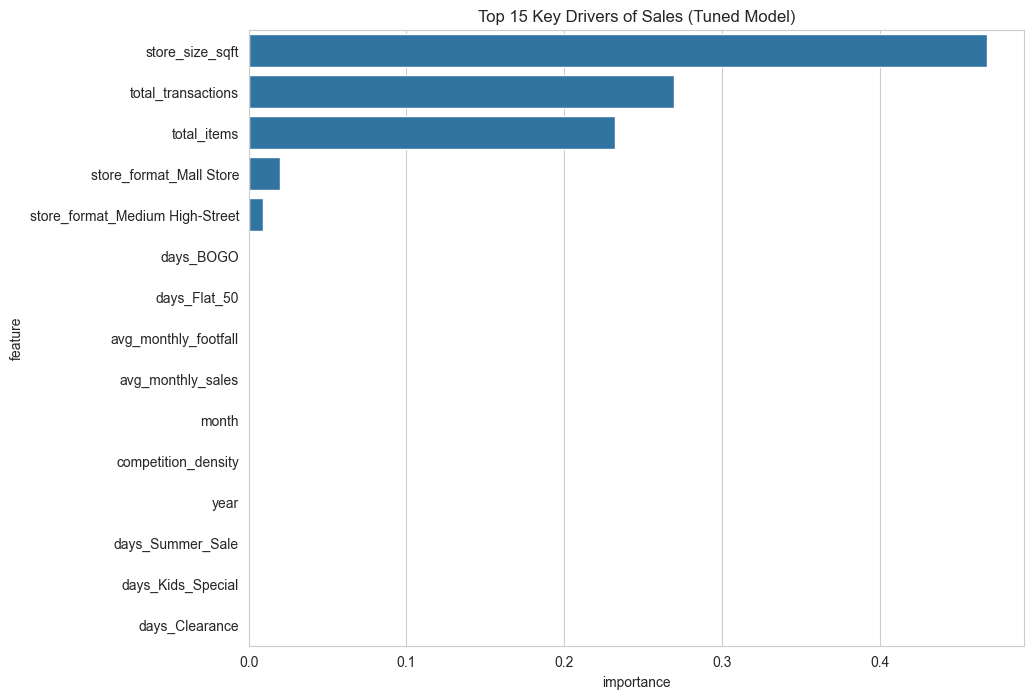

In [50]:
# Feature Importance
# Use X_train_scaled.columns because X.columns (raw) no longer matches the transformed features.
feature_importances = pd.DataFrame({
    'feature': X_train_scaled.columns, 
    'importance': best_rf.feature_importances_
}).sort_values('importance', ascending=False)

fig, ax = plt.subplots(figsize=(10, 8))
sns.barplot(data=feature_importances.head(15), x='importance', y='feature', ax=ax)
ax.set_title('Top 15 Key Drivers of Sales (Tuned Model)')
plt.show()
